In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
import numpy as np
from scipy.stats import kendalltau
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
def read_memfile(filename, shape, dtype='float32'):
    # read binary data and return as a numpy array
    fp = np.memmap(filename, dtype=dtype, mode='r', shape=shape)
    data = np.zeros(shape=shape, dtype=dtype)
    data[:] = fp[:]
    del fp
    return data

In [5]:
def write_memfile(data, filename):
    # write a numpy array 'data' into a binary  data file specified by
    # 'filename'
    shape = data.shape
    dtype = data.dtype
    fp = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)
    fp[:] = data[:]
    del fp

In [6]:
ROOT_DIR = '/rap/jvb-000-aa/COURS2019/etudiants/data/omsignal/myHeartProject/'
TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE =  'MILA_ValidationLabeledData.dat'

TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE = 'MILA_ValidationLabeledData.dat'
LABELS_NAME = ["PR_Mean", "RT_Mean", "RR_StdDev", "ID"]

train_labeled_data_file = os.path.join(ROOT_DIR, TRAIN_LABELED_FILE)
validation_labeled_data_file = os.path.join(ROOT_DIR, VALIDATION_LABELED_FILE)

In [7]:
datatrain = read_memfile(train_labeled_data_file, shape=(160,3754))
train_data, train_labels = datatrain[:,:-4], datatrain[:,-4:]

In [8]:
datavalid = read_memfile(validation_labeled_data_file, shape=(160,3754))
valid_data, valid_labels = datavalid[:,:-4], datavalid[:,-4:]

In [9]:
class Preprocessor(nn.Module):

    def __init__(
            self,
            ma_window_size=2,
            mv_window_size=4,
            num_samples_per_second=125):
        # ma_window_size: (in seconds) window size to use
        #                 for moving average baseline wander removal
        # mv_window_size: (in seconds) window size to use
        #                 for moving average RMS normalization

        super(Preprocessor, self).__init__()

        # Kernel size to use for moving average baseline wander removal: 2
        # seconds * 125 HZ sampling rate, + 1 to make it odd

        self.maKernelSize = (ma_window_size * num_samples_per_second) + 1

        # Kernel size to use for moving average normalization: 4
        # seconds * 125 HZ sampling rate , + 1 to make it odd

        self.mvKernelSize = (mv_window_size * num_samples_per_second) + 1

    def forward(self, x):

        with torch.no_grad():
            x = x.unsqueeze(0)
            

            # Remove window mean and standard deviation

            x = (x - torch.mean(x, dim=2, keepdim=True)) / \
                (torch.std(x, dim=2, keepdim=True) + 0.00001)

            # Moving average baseline wander removal

            x = x - F.avg_pool1d(
                x, kernel_size=self.maKernelSize,
                stride=1, padding=(self.maKernelSize - 1) // 2
            )

            # Moving RMS normalization

            x = x / (
                torch.sqrt(
                    F.avg_pool1d(
                        torch.pow(x, 2),
                        kernel_size=self.mvKernelSize,
                        stride=1, padding=(self.mvKernelSize - 1) // 2
                    )) + 0.00001
            )

        # Don't backpropagate further

        x = x.detach().contiguous()

        return x.squeeze(0)

In [10]:
def Plot_ECG(data, start=0, end=30, index_nb=[0], seconde=True):
    """
    Plot the ECG on a user defined time interval
    
    Parameters
    ----------
    data : numpy array
        The ECG Data
    start: int
        The starting time of the part of the ECG you want to plot
    end: int
        The End time of the part of the ECG you want to plot
    index_nb: List
        The index of the observation you want to plot
    seconde: boolean
        Used True if the start time is in seconde
    """
    # Adjust the shape in order to have 2 dimension
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=0)
        
    # Transform the start and end time 
    if seconde == True:
        start = start*125
        end = end*125
        
    x_labels = np.arange(start, end)
             
    for i, ex in enumerate(index_nb):
        plt.figure(i*2+1) 
        plt.plot(x_labels, data[ex, start:end])
        
    plt.show

In [22]:
class id_trasformer:
    def __init__(self):
        self.DictId2Class = {}
        self.DictClass2Id = {}
        self.n_Id = 0 
        
    def create_dict_ID(self, ID_vector):
        for id in ID_vector:
            if id not in self.DictId2Class:
                self.DictId2Class[id] = self.n_Id
                self.DictClass2Id[self.n_Id] = id
                self.n_Id += 1
                
    def Id2Class(self, ID_vector):
        return [self.DictId2Class[id] for id in ID_vector]
    
    def Class2Id(self, class_vector):
        return [self.DictClass2Id[labels] for labels in class_vector]

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [12]:
preprocessor = Preprocessor().to(device)

In [13]:
train = torch.tensor(train_data).to(device)
valid =  torch.tensor(valid_data).to(device)
preprocess_train = preprocessor(train)
preprocess_valid = preprocessor(valid)

In [23]:
idtransformer = id_trasformer()
idtransformer.create_dict_ID(train_labels[:,-1])
train_labels[:,-1] = idtransformer.Id2Class(train_labels[:,-1])
valid_labels[:,-1] = idtransformer.Id2Class(valid_labels[:,-1])

Algo to detect R P,T peak and onset offset based on https://pure.tugraz.at/ws/portalfiles/portal/1312717/Online%20and%20Offline%20Determination%20of%20QT%20PR%20in%20Electrocardiography%20LNCS%207719.pdfdf.pdf

In [14]:
def detect_R_peak(data, SADA_wd_size = 7, FS_wd_size = 12, Threshold = 35):
    """
    Take a Batch of ECG data and find the location of the R Peak
    
    The algorithm is based on the paper:
    Online and Offline Determination of QT and PR Interval and QRS Duration in Electrocardiography
    (Bachler et al., 2012)
    The variable name and default value follow the paper
    
    Parameters
    ----------
    data : numpy array
        The ECG Data (batch size x lenght of the ECG recording)
    SADA_wd_size: int
        size of the moving window used in the calculation of SA and DA
    FS_wd_size: int
        size of the moving window used in the calculation of the feature signal FS
    Threshold: int
        FS is compared to the Threshold to determined if its a QRS zone. 
    """
    
    R_peak = []
    
    #Allow batch size of 1
    if len(data.size()) == 1:
        data = data.unsqueeze(0)
    
    D = data[:, 1:] - data[:, 0:-1]
    
    
    data = data.unsqueeze(0)
    D = D.unsqueeze(0)
    SA = F.max_pool1d(data, kernel_size = SADA_wd_size, stride = 1)
    SA = SA + F.max_pool1d(-data, kernel_size = SADA_wd_size, stride = 1) 
    DA = F.max_pool1d(D, kernel_size = SADA_wd_size, stride = 1, padding=1)
    DA = DA + F.max_pool1d(-D, kernel_size = SADA_wd_size, stride = 1, padding=1) 
    
    C = DA[:,:,1:] * torch.pow(SA, 2)
    FS = F.max_pool1d(C, kernel_size = FS_wd_size, stride = 1) 
    Detect = (FS > Threshold)
    
    Detect = Detect.squeeze(0).cpu()
    data = data.squeeze(0).cpu()

    for ECG in range(len(data)):
        
        in_QRS = 0
        start_QRS = 0
        end_QRS = 0
        r_peak = np.array([])
        
        for tick, detect in enumerate(Detect[ECG]):
            
            if (in_QRS == 0) and (detect == 1):
                start_QRS = tick
                in_QRS = 1
                
            elif (in_QRS == 1) and (detect == 0):
                end_QRS = tick
                R_tick = torch.argmax(data[ECG, start_QRS : end_QRS+SADA_wd_size+FS_wd_size]).item()
                r_peak = np.append(r_peak, R_tick + start_QRS)
                in_QRS = 0
                start_QRS = 0
                
        R_peak.append(r_peak)
        
    return R_peak

In [15]:
R_peak_train = detect_R_peak(preprocess_train)
R_peak_valid = detect_R_peak(preprocess_valid)

In [125]:
RR_interval = [R_peak[i][1:]-R_peak[i][0:-1] for i in range(len(R_peak))]
#We keep only good quality one
RR_interval_adj = [interval[interval<180] for interval in RR_interval]
RR_interval_mean = [np.mean(interval) for interval in RR_interval_adj]
heart_beat = [1/(interval_mean/125)*60 for interval_mean in RR_interval_mean]
RR_std = [np.std(interval) for interval in RR_interval_adj]

In [73]:

def create_template(data, R_peak, template_size = 110, All_window = True):
    
    listoftemplate = np.empty((1,template_size))
    
    for recording in range(len(R_peak)):
        #generate the template
        half_size_int = int(template_size//2)
        template = np.zeros((1,template_size))
        
        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            #add padding to make them all of the same size
            current_size = int(half_size_int*0.8)+int(half_size_int*1.2)
            
                
            template = np.concatenate((template,
                                       np.expand_dims(new_heart_beat, axis = 0))
                                       , axis=0)

        if All_window == False:
            template = np.mean(template, axis = 0)
            template = np.expand_dims(template, axis = 0)
        
        listoftemplate = np.append(listoftemplate, template, axis = 0)
    
    return listoftemplate[1:]

In [74]:
template_train.shape

(5157, 110)

In [75]:
template_valid = create_template(preprocess_train.cpu().numpy(), R_peak_train)
template_train = create_template(preprocess_valid.cpu().numpy(), R_peak_valid)

In [52]:
shuffle = np.random.permutation(160)
train_shuffle = template_train[shuffle]
TrainLabel_shuffle = train_labels[shuffle]
shuffle = np.random.permutation(160)
valid_shuffle = template_valid[shuffle]
ValidLabel_shuffle = valid_labels[shuffle]

In [53]:
from sklearn.decomposition import PCA

In [65]:
ipca = PCA(n_components=25)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [60]:
lda = LinearDiscriminantAnalysis()
lda.fit(pca_train, TrainLabel_shuffle[:,-1])
y_pred = lda.predict(pca_valid)
lda.score(pca_valid, ValidLabel_shuffle[:,-1])

0.79375

In [61]:
ecgIdAccuracy = recall_score(ValidLabel_shuffle[:,-1], y_pred, average='macro')
adjustementTerm = 1.0 / len(np.unique(ValidLabel_shuffle[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.7870967741935483


In [67]:
pca_transform

NameError: name 'pca_transform' is not defined

In [102]:
listoftemplate[1:]

array([[-0.25338975, -0.24917247, -0.25274529, ..., -0.25576503,
        -0.28740021, -0.29173541],
       [-0.24376676, -0.26171796, -0.28833485, ..., -0.43178901,
        -0.44834672, -0.45985952],
       [-0.04849116, -0.0463699 , -0.06121177, ..., -0.07391912,
        -0.07794355, -0.09305795],
       ...,
       [ 0.01973739, -0.02789447, -0.07949318, ..., -0.24167573,
        -0.21180793, -0.19415576],
       [-0.25095649, -0.27646724, -0.28469655, ..., -0.21295203,
        -0.23502796, -0.2713852 ],
       [-0.2504455 , -0.25440335, -0.25353932, ..., -0.2000341 ,
        -0.20901477, -0.2305932 ]])

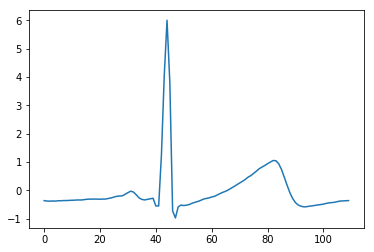

In [104]:
Plot_ECG(listoftemplate[8],start=0,end=110,seconde = False)

In [16]:
R_peak_amplitude = [[preprocess_train[i][int(j)] for j in record] for i, record in enumerate(R_peak)]

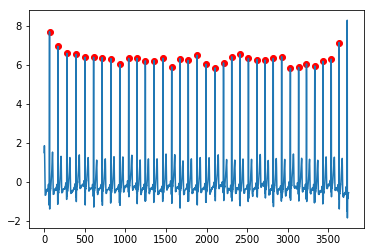

In [18]:
plt.plot(R_peak[5],R_peak_amplitude[5],"ro")
Plot_ECG(preprocess_train[5].cpu(),start=0,end=30)

In [ ]:
RR_interval = [R_peak[i][1:]-R_peak[i][0:-1] for i in range(len(R_peak))]

for i in range(len(RR_std)):
    print((i,RR_std[i], train_labels[i,-2]))

In [ ]:
plt.plot(RR_std, train_labels[:,-2], "ro")

In [ ]:
kendalltau(RR_std, train_labels[:,-2])

"PR_Mean", "RT_Mean"

In [33]:
S_numpy = preprocess_train.cpu().numpy()

In [34]:
listoftemplate = []
listofQRS_offset = []
listofT_peak = []
listofT_offset = []
listofQRS_onset = []
listofP_peak = []
listofP_onset = []
listofR_Peak = []


for recording in range(len(R_peak)):
    #generate the template
    half_size_int = int(RR_interval_mean[recording]//2)
    template = np.ones((1,int(half_size_int*0.8)+int(half_size_int*1.2)))
    for i in R_peak[recording][1:-1]:
        new_heart_beat = S_numpy[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
        template = np.concatenate((template,
                                   np.expand_dims(new_heart_beat, axis = 0))
                                   , axis=0)
    
    
    template = np.mean(template, axis = 0)
    
    #find QRS offset
    derivative = template[1:] - template[:-1] 
    TA = np.array([])
    TDA = np.array([])
    for i in range(int(half_size_int*0.8)+1, int(half_size_int*0.8)+25):
        TA = np.append(TA,np.max(template[i:i+4]) - np.min(template[i:i+4])) 
        TDA = np.append(TDA,np.max(derivative[i:i+4]) - np.min(derivative[i:i+4]))
    c1 = 0.1
    c2 = 0.1
    TT = c1 * (np.max(TA) - np.min(TA)) + np.min(TA)
    TD = c2 * (np.max(TDA) - np.min(TDA)) + np.min(TDA)
    
    for i in range(0, len(TA)):
        if TA[i] < TT or TDA[i] < TD:
            QRS_offset = i + int(half_size_int*0.8) + 4
            break
        
    #find T peak
    T_peak = QRS_offset + np.argmax(template[QRS_offset:])
    
    #find T wave offset
    
    k = (template[T_peak] - template[-1])/(T_peak-len(template))
    d = template[-1] - k*len(template)
    g = k*np.arange(0,len(template)) + d
    decision = template - g
    T_peak_offset = np.argmin(decision[T_peak:len(template)]) + T_peak
    
    #reverse the template
    reverse_template = np.flip(template)
    
    #Find the QRS onset
    derivative = reverse_template[1:] - reverse_template[:-1] 
    TA = np.array([])
    TDA = np.array([])
    for i in range(int(half_size_int*1.2)+1, int(half_size_int*1.2)+25):
        TA = np.append(TA,np.max(reverse_template[i:i+4]) - np.min(reverse_template[i:i+4])) 
        TDA = np.append(TDA,np.max(derivative[i:i+4]) - np.min(derivative[i:i+4]))
    c1 = 0.5
    c2 = 0.5
    TT = c1 * (np.max(TA) - np.min(TA)) + np.min(TA)
    TD = c2 * (np.max(TDA) - np.min(TDA)) + np.min(TDA)
    
    for i in range(0, len(TA)):
        if TA[i] < TT or TDA[i] < TD:
            QRS_onset = i + int(half_size_int*1.2) + 4
            break
    
    #Find the P peak
    P_peak = QRS_onset + np.argmax(reverse_template[QRS_onset:])  
    
    #Find the P onset
    
    k = (reverse_template[P_peak] - reverse_template[-1])/(P_peak-len(reverse_template))
    d = reverse_template[-1] - k*len(reverse_template)
    g = k*np.arange(0,len(reverse_template)) + d
    decision = reverse_template - g
    P_onset = np.argmin(decision[P_peak:len(reverse_template)]) + P_peak
    
    
    P_peak = len(template)-P_peak-1
    QRS_onset = len(template)-QRS_onset-1
    P_onset = len(template)-P_onset-1
    
    
    listofR_Peak.append(int(half_size_int*0.8)+1)
    listoftemplate.append(template)
    listofQRS_offset.append(QRS_offset)
    listofT_peak.append(T_peak)
    listofT_offset.append(T_peak_offset)
    listofQRS_onset.append(QRS_onset)
    listofP_peak.append(P_peak)
    listofP_onset.append(P_onset)
    

In [ ]:
RT_Mean = [T_peak-R_peak+1 for T_peak,R_peak in zip(listofT_peak,listofR_Peak)]
PR_Mean = [R_peak-P_onset for R_peak,P_onset in zip(listofR_Peak,listofP_peak)]

In [ ]:
PR_Mean2 = [QRS_onset-P_onset for QRS_onset,P_onset in zip(listofQRS_onset,listofP_onset)]

In [ ]:
plt.plot(PR_Mean, train_labels[:,0], "ro")

In [ ]:
kendalltau(PR_Mean, train_labels[:,0])

In [ ]:
plt.plot(RT_Mean, train_labels[:,-3], "ro")

In [ ]:
kendalltau(RT_Mean, train_labels[:,-3])

In [ ]:
index_nb = 8
vizualize_ECG(listoftemplate[index_nb],0,len(listoftemplate[index_nb]),seconde=False)
plt.plot(listofR_Peak[index_nb]-1, listoftemplate[index_nb][listofR_Peak[index_nb]-1], "o")
plt.plot(listofQRS_offset[index_nb], listoftemplate[index_nb][listofQRS_offset[index_nb]], "o")
plt.plot(listofT_peak[index_nb], listoftemplate[index_nb][listofT_peak[index_nb]], "o")
plt.plot(listofT_offset[index_nb], listoftemplate[index_nb][listofT_offset[index_nb]], "o")
plt.plot(listofQRS_onset[index_nb], listoftemplate[index_nb][listofQRS_onset[index_nb]], "o")
plt.plot(listofP_peak[index_nb], listoftemplate[index_nb][listofP_peak[index_nb]], "o")
plt.plot(listofP_onset[index_nb], listoftemplate[index_nb][listofP_onset[index_nb]], "o")
plt.legend(["","R","QRS offset", "T", "T offset", "QRS onset","P", "P onset" ])

Lets try to improve the result by adding a layer of machine learning

In [110]:
import pandas as pd

In [111]:
ECG_train = pd.DataFrame()

In [113]:
ECG_train["heartbeat"] = RR_interval_mean
ECG_train["RR_std"] = RR_std
ECG_train["RT_Mean"] = RT_Mean
ECG_train["PR_Mean"] = PR_Mean
ECG_train["QRS_len"] = [QRS_offset-QRS_onset for QRS_offset,QRS_onset in zip(listofQRS_offset,listofQRS_onset)]
ECG_train["RT_Mean2"] = [T_offset-QRS_offset for T_offset,QRS_offset in zip(listofT_offset,listofQRS_offset)]
ECG_train["PR_Mean2"] =[QRS_onset-P_onset for QRS_onset,P_onset in zip(listofQRS_onset,listofP_onset)]
ECG_train["PT_Mean"] =[T_peak-P_peak for T_peak,P_peak in zip(listofT_peak,listofP_peak)]
ECG_train["R_peak_amplitude"] = [listoftemplate[index_nb][R_peak-1] for index_nb, R_peak in enumerate(listofR_Peak)]
ECG_train["P_peak_amplitude"] = [listoftemplate[index_nb][P_peak] for index_nb, P_peak in enumerate(listofP_peak)]
ECG_train["T_peak_amplitude"] = [listoftemplate[index_nb][T_peak] for index_nb, T_peak in enumerate(listofT_peak)]

In [126]:
idtransformer = id_trasformer()
idtransformer.create_dict_ID(train_labels[:,-1])
train_labels[:,-1] = idtransformer.Id2Class(train_labels[:,-1])
valid_labels[:,-1] = idtransformer.Id2Class(valid_labels[:,-1])

In [116]:
x_valid = np.array(ECG_train)

In [61]:
x=np.array(ECG_train)

In [129]:
shuffle = np.random.permutation(160)
train_shuffle = x[shuffle]
TrainLabel_shuffle = train_labels[shuffle]
valid_shuffle = x_valid[shuffle]
ValidLabel_shuffle = valid_labels[shuffle]

ID task this will give a baseline to beat

In [171]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [174]:
forest = LinearDiscriminantAnalysis()
forest.fit(train_shuffle, TrainLabel_shuffle[:,-1])
y_pred = forest.predict(valid_shuffle)
forest.score(valid_shuffle, ValidLabel_shuffle[:,-1])

/miniconda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.48125

In [134]:
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0, oob_score=True, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-1])
print(forest.oob_score_)
y_pred = forest.predict(valid_shuffle)
forest.score(valid_shuffle, ValidLabel_shuffle[:,-1])

0.78125


0.45

In [175]:
ecgIdAccuracy = recall_score(ValidLabel_shuffle[:,-1], y_pred, average='macro')
adjustementTerm = 1.0 / len(np.unique(ValidLabel_shuffle[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.46451612903225814


Regression Task

In [152]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-2])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-2])

KendalltauResult(correlation=0.841621133556427, pvalue=3.361077295023981e-56)

In [153]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-3])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-3])

KendalltauResult(correlation=0.8685327989136057, pvalue=1.0143556843011926e-59)

In [154]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-4])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-4])

KendalltauResult(correlation=0.843528867168673, pvalue=1.9595342735005284e-56)

No improvement here

In [156]:
from sklearn.linear_model import LinearRegression

In [160]:
for i in range(3):
    linear = LinearRegression()
    linear.fit(train_shuffle, TrainLabel_shuffle[:,i])
    y_pred = linear.predict(valid_shuffle)
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i]))

KendalltauResult(correlation=0.7024689503434867, pvalue=1.1128367743913108e-39)
KendalltauResult(correlation=0.8812706509346092, pvalue=1.975081609541191e-61)
KendalltauResult(correlation=0.8350171003739197, pvalue=2.380900142611868e-55)


No improvement also

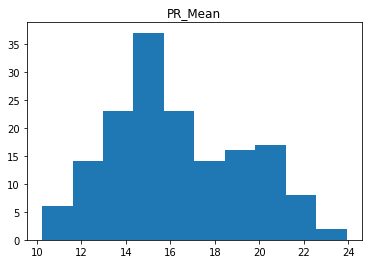

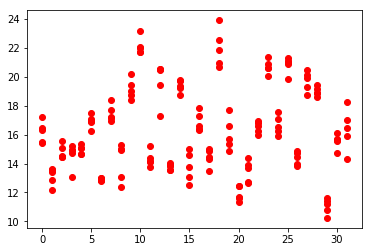

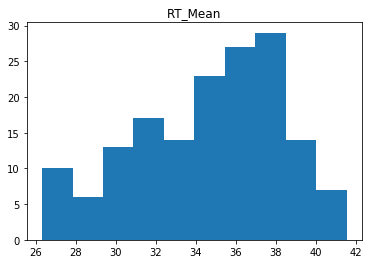

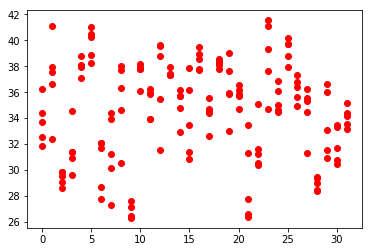

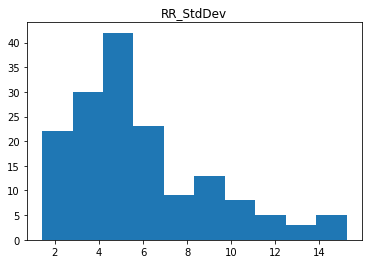

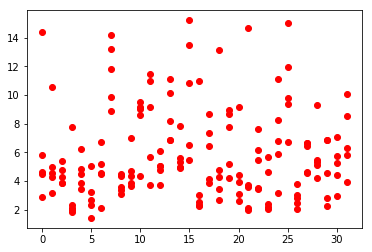

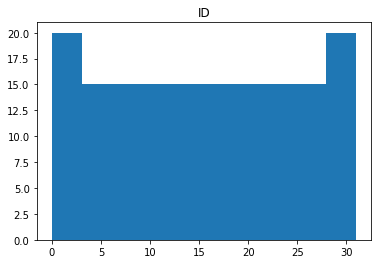

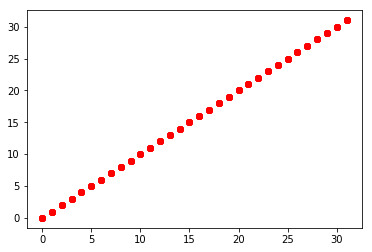

In [23]:
def vizualize_label(label_name=LABELS_NAME, type_data=train_labels):
    # Plot histogram of the label to see their distribution
    # Not complete 
    for i, ex in enumerate(label_name):
        plt.figure(i*2+1) #to let the index start at 1
        plt.title(ex)
        plt.hist(train_labels[:,i])
        plt.figure(i*2+2)
        plt.plot(train_labels[:,-1], train_labels[:,i],"ro")
    plt.show()
    
vizualize_label()